# **Federaated Learning with TinyML - Notebook GUIA**

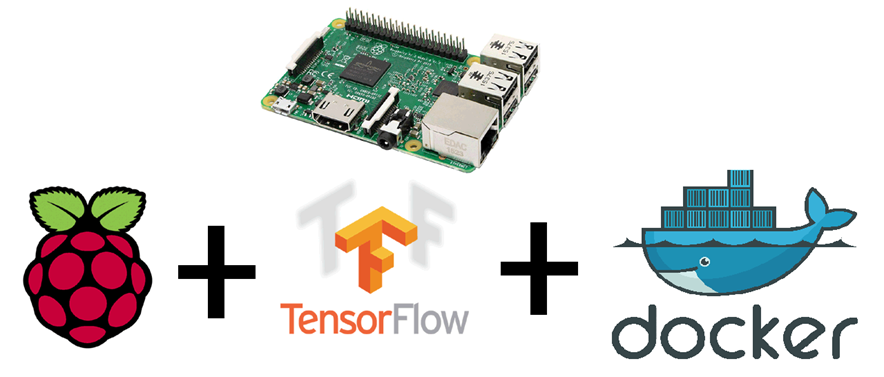

 
Neste laboratório, exploraremos o uso do aprendizado federado com o TinyML. A ideia é usar os códigos apresentados para gerar um ambiente isolado para os clientes e o servidor. Para isso, usaremos o DOCKER, que nos permitirá ter portabilidade, isolamento, eficiência de recursos e implantação rápida em cada um dos clientes.


**Objetivos**:
1. Executar um servidor e dois clientes que treinam um modelo CNN no dataset MNIST.
2. Observar como o aprendizado federado distribui os dados entre clientes.
3. Entender o fluxo de comunicação entre o servidor e os clientes.
"""

GitHub Link to download or clone the code: 

# Configuracion del ambiente

### Docker (Download para o LINUX)

**Abra um terminal, copie e cole as seguintes linhas, uma a uma**

sudo apt-get update
sudo apt-get upgrade

sudo apt-get install apt-transport-https ca-certificates curl software-properties-common

curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo apt-key add -

sudo add-apt-repository "deb [arch=amd64] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable"

sudo apt-get update
sudo apt-get install docker-ce

sudo systemctl status docker

# Server

### requitements_tf.txt

* flwr>=1.0, <2.0
* flwr-datasets[vision]>=0.0.2, <1.0.0
* tensorflow >=2.9.1, != 2.11.1

### Dockerfile

crie um dockerfile dentro da pasta onde criaremos o server.py. O contêiner instala todas as dependências que serão usadas para a execução correta do script.

In [ ]:
# Imagen base de Python
FROM python:3.12-slim

# Update pip
RUN pip3 install --upgrade pip

# Crear un directorio de trabajo
WORKDIR /app

# Install flower
RUN pip3 install flwr>=1.0
RUN pip3 install flwr-datasets>=0.0.2
RUN pip3 install tqdm==4.65.0
RUN pip3 install tensorflow >=2.9.1

# Copiar el archivo del cliente al contenedor
COPY server.py /app/server.py

# Comando para ejecutar el cliente
CMD ["python", "server.py"]

### server.py

In [ ]:
import argparse
from typing import List, Tuple
import flwr as fl
from flwr.common import Metrics

Essa parte será usada caso o usuário queira inicializar o script com alguns argumentos, como o endereço do servidor, o número de clientes e o número de clientes que serão usados para as etapas de treinamento.

In [ ]:
# Commands that could be executed just before running the script
parser = argparse.ArgumentParser(description="Flower Embedded devices")
parser.add_argument(
    "--server_address",
    type=str,
    default="0.0.0.0:8085",
    help=f"gRPC server address (deafault '0.0.0.0:8085')",
)
parser.add_argument(
    "--sample_fraction",
    type=float,
    default=1.0, #Will be used 100% of clients to train and evaluate the model
    help="Fraction of available clients used for fit/evaluate (default: 1.0)",
)
parser.add_argument(
    "--min_num_clients",
    type=int,
    default=2,
    help="Minimum number of available clients required for sampling (default: 2)",
)

A função weighted_average() é uma função da estrutura de Flower que é usada para calcular a média das métricas de avaliação recebidas pelos clientes; os clientes com mais dados têm um impacto maior nas métricas gerais. 

In [ ]:
# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """ after the train phase and evaluation, clients send the metrics such as 
    "Accuracy", and these are aggregated for this function through the weighted average"""
    # Multiply accuracy of each client by number of examples used
     # Clients with more data gets a higher weight in global metrics
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

A função fit_config() usa as variáveis epochs e batch_size para o treinamento do modelo. Nesse caso, foi usado um tamanho de lote de 16 devido à baixa RAM do Raspberry.

In [ ]:
def fit_config(server_round: int):
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 3,  # Number of local epochs done by clients
        "batch_size": 16,  # Batch size to use by clients during fit()
    }
    return config

essa função inicia a execução das funções já mostradas.

In [ ]:
def main():
    args = parser.parse_args()

    print(args)

    # Define strategy
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=args.sample_fraction,
        fraction_evaluate=args.sample_fraction,
        min_fit_clients=args.min_num_clients,
        on_fit_config_fn=fit_config,
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Start Flower server
    fl.server.start_server(
        server_address=args.server_address,
        config=fl.server.ServerConfig(num_rounds=5), # Number of rounds that the server will do, depend on the embedding devices
        strategy=strategy,
    )


if __name__ == "__main__":
    main()

# client 1 and 2

### requirements.txt

* flwr>=1.0, <2.0
* flwr-datasets[vision]>=0.0.2, <1.0.0
* tensorflow >=2.9.1, != 2.11.1

### Dockerfile

In [ ]:
# Imagen base de Python
FROM python:3.12-slim

# Update pip
RUN pip3 install --upgrade pip

# Crear un directorio de trabajo
WORKDIR /app

# Install flower
RUN pip3 install flwr>=1.0
RUN pip3 install flwr-datasets>=0.0.2
RUN pip3 install tqdm==4.65.0
RUN pip3 install tensorflow >=2.9.1

# Copiar el archivo del cliente al contenedor
COPY client_2.py /app/client_2.py

# Comando para ejecutar el cliente
CMD ["python", "client_2.py", "--server_address=192.168.1.1:8085", "--cid=1"] 

### client_1 and client_2

<center>
    <img src="https://http2.mlstatic.com/D_NQ_NP_607796-MLA79897643708_102024-O.webp" alt="Descripción de la imagen" width="500"/>
</center>



In [ ]:
import argparse
import warnings

import flwr as fl
from flwr_datasets import FederatedDataset
from tensorflow import keras as keras

In [ ]:
parser = argparse.ArgumentParser(description="Flower Embedded devices")
parser.add_argument(
    "--server_address",
    type=str,
    default="192.168.1.1:8085",
    help=f"gRPC server address (default '192.168.1.2:8085')",
)
parser.add_argument(
    "--cid", # Container id, this is ideal to ideantify each container and make the dataset partition with IID data
    type=int,
    required=True,
    help="Client id. Should be an integer between 0 and NUM_CLIENTS",
)

Com a linha a seguir, podemos ignorar alguns avisos que não são essenciais para a execução do código e que podem gerar ruído.

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
NUM_CLIENTS = 2 

A função prepare_dataset () é responsável por fazer o download do conjunto de dados MNIST e particioná-lo de acordo com o número de clientes. Seu particionamento é aleatório para gerar dados IID e é gerado graças à linha  * fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})

In [ ]:
def prepare_dataset():
    """Download and partition the MNIST dataset."""
    # MNNIST
    fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS}) # dataset="cifar10"   --> if you want to use dataset cifar10
    img_key = "image" # img  --> if you want to use dataset cifar10
    partitions = []
    
    for partition_id in range(NUM_CLIENTS): # the dataset is partitioned deppending on the number of clients available
        partition = fds.load_partition(partition_id, "train")
        partition.set_format("numpy")
        # Divide data on each node: 80% train, 20% test
        partition = partition.train_test_split(test_size=0.2, seed=42)
        x_train, y_train = (
            partition["train"][img_key] / 255.0,
            partition["train"]["label"],
        )
        x_test, y_test = partition["test"][img_key] / 255.0, partition["test"]["label"]
        partitions.append(((x_train, y_train), (x_test, y_test)))
    
    data_centralized = fds.load_split("test")
    data_centralized.set_format("numpy")
    x_centralized = data_centralized[img_key] / 255.0
    y_centralized = data_centralized["label"]
    
    return partitions, (x_centralized, y_centralized)

A classe FlowerClient(fl.client.NumPyClient) inicializa o cliente e chama as funções de acordo com sua necessidade. Isso é feito pela estrutura do Flower

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    """A FlowerClient that uses a smaller CNN for MNIST."""
    
    def __init__(self, trainset, valset):
        self.x_train, self.y_train = trainset
        self.x_val, self.y_val = valset
        # Instantiate model for MNIST
        self.model = keras.Sequential(
            [
                keras.Input(shape=(28, 28, 1)),  # (32, 32, 3)   ---> if you want to use dataset CIFAR10
                keras.layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
                keras.layers.MaxPooling2D(pool_size=(2, 2)),
                keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size=(2, 2)),
                keras.layers.Flatten(), # Unidimensional vector
                keras.layers.Dropout(0.5), # turn off 50% of perceptrons to improve the generalization - Randomly
                keras.layers.Dense(10, activation="softmax"),
            ]
        )
        self.model.compile(
            "adam", "sparse_categorical_crossentropy", metrics=["accuracy"]
        )

    def get_parameters(self, config): # Server gets the weights from the trained model.
        return self.model.get_weights()

    def set_parameters(self, params): #  weights are updated in the client sent by the server
        self.model.set_weights(params)

    def fit(self, parameters, config): # Train the model with the client data
        print("Client sampled for fit()")
        self.set_parameters(parameters)
        # Set hyperparameters from config sent by server/strategy
        batch, epochs = config["batch_size"], config["epochs"]
        # Train the model
        self.model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch)
        return self.get_parameters({}), len(self.x_train), {}

    def evaluate(self, parameters, config): # Evaluate the model with the validation data of the client
        print("Client sampled for evaluate()")
        self.set_parameters(parameters)
        loss, accuracy = self.model.evaluate(self.x_val, self.y_val)
        return loss, len(self.x_val), {"accuracy": accuracy}

In [ ]:
def main():
    args = parser.parse_args()
    print(args)

    assert args.cid < NUM_CLIENTS # Be aware that there are not more clients that the user requests

    # Always use MNIST dataset
    partitions, _ = prepare_dataset()
    trainset, valset = partitions[args.cid]

    # Start Flower client setting its associated data partition
    fl.client.start_client(
        server_address=args.server_address,
        client=FlowerClient(
            trainset=trainset, valset=valset
        ).to_client(),
    )


if __name__ == "__main__":
    main()

A distribuição das pastas deve ser a seguinte ou as seguintes

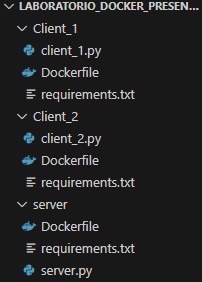